# Stacking

Le stacking est une stratégie puissante d'apprentissage en Machine Learning qui combine les prédictions de nombreux modèles de base pour obtenir une prédiction finale avec de meilleures performances. Contrairement au Boosting, qui consiste à combiner plusieurs prédicteurs faibles identiques, le Stacking combine plusieurs modèles hétérogènes, qui ne sont pas nécessairement identiques, et qui doivent également être performants.


L'idée principale est donc d'alimenter les prédictions de nombreux modèles de base dans un modèle de niveau supérieur connu sous le nom de méta-modèle.

Les modèles de base sont généralement sélectionnés de manière à garantir qu'ils produisent différents types d'erreurs et qu'ils se complètent mutuellement.

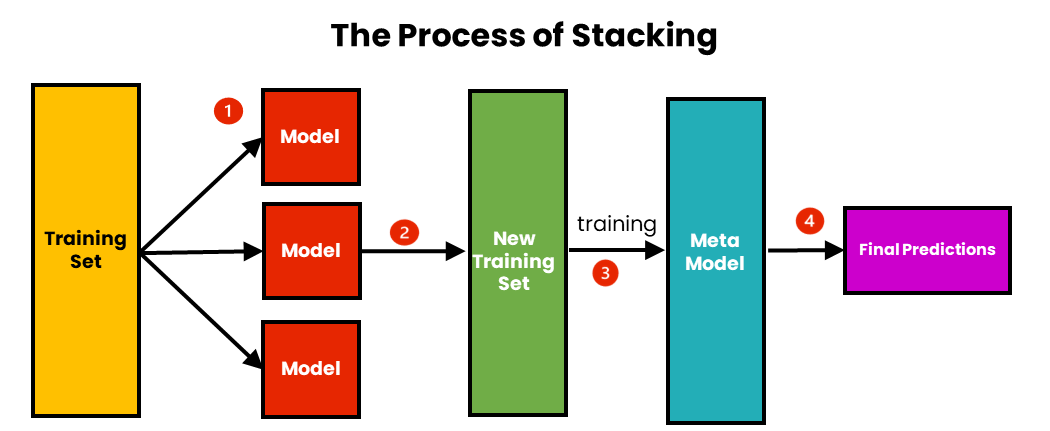

In [2]:
from IPython.display import Image
image_path = "/home/jovyan/github intro/stacking.png"
width = 500
height = 500
Image(filename=image_path, width=width, height=height)

Les étapes de cette stratégie sont les suivantes:
- Nous devons diviser les données en trois ensembles : par exemple 70\% pour l'entraînement, 10\% pour la validation et 20\% pour les tests.

- Les modèles de bases doivent etre ensuite entrainés sur les données d'entraînement, puis prédisent sur les données de validation. 

- Le méta-modèle est ensuite entraîné en utilisant les prédictions obtenues par les modèles de base sur l'ensemble de validation. Ainsi, les variables dans la base de données ne sont plus les entrées du méta-modèle, mais plutôt les prédictions des modèles de base qui sont utilisées comme caractéristiques pour le méta-modèle.

- Les modèles de base sont utilisés pour faire des prédictions sur les données de test. 

- Les prédictions sur les données de test faites par les modèles de base sont enfin utilisées pour que le méta-modèle fasse des prédictions dessus. 

# Stacking with Scikit-Learn

In [1]:
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Comme dans d'autres scripts, la base de données utilisée est Titanic de python.

In [2]:
df = sns.load_dataset('titanic')
df = pd.DataFrame(df)
df = df[["pclass", "sex", "age", "fare", "class" ,"survived"]]
df

,pclass,sex,age,fare,class,survived
0,3,male,22.0,7.2500,Third,0
1,1,female,38.0,71.2833,First,1
2,3,female,26.0,7.9250,Third,1
3,1,female,35.0,53.1000,First,1
4,3,male,35.0,8.0500,Third,0
...,...,...,...,...,...,...
886,2,male,27.0,13.0000,Second,0
887,1,female,19.0,30.0000,First,1
888,3,female,NaN,23.4500,Third,0
889,1,male,26.0,30.0000,First,1


**Imputation des valeurs manquantes**

In [3]:
df.isnull().sum()

pclass        0
sex           0
age         177
fare          0
class         0
survived      0
dtype: int64

In [4]:
df['age'] = df['age'].fillna(df['age'].median())

**Encodage des variables catégorielles**

In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OrdinalEncoder

#sex
lb = LabelBinarizer()
df["sex"] = lb.fit_transform(df["sex"])

#class
ordinal_encoder = OrdinalEncoder()
df[["class"]] = ordinal_encoder.fit_transform(df[["class"]])

In [6]:
X = df.drop('survived', axis=1)
y = df[["survived"]]

**Division des données en 20% données de test, 10% données de validation et 70% données d'entraînement** 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2,random_state=15,shuffle=True,stratify=y)  
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.1,random_state=15,shuffle=True,stratify=Y_train)  

In [8]:
print("Y_train:\n",  Y_train.value_counts(), 
    "\nY_test:\n", Y_test.value_counts() 
    ,"\nY_valid:\n", Y_val.value_counts())

Y_train:
 survived
0           395
1           245
Name: count, dtype: int64 
Y_test:
 survived
0           110
1            69
Name: count, dtype: int64 
Y_valid:
 survived
0           44
1           28
Name: count, dtype: int64


# Détermination des modèles

**Les modèles de base:**

Il faut optimiser les hyperparamètres des modèles de base avant de les utiliser dans un modèle de stacking (ou empilement). L'optimisation des hyperparamètres permet d'obtenir des modèles de base qui sont déjà performants individuellement, ce qui peut améliorer les performances globales du modèle de stacking. 

Il est en effet important que les modèles de base présentent une diversité en termes de leur mode de fonctionnement. La diversité entre les modèles de base peut contribuer à améliorer les performances du modèle de stacking en permettant au méta-modèle d'apprendre des modèles de base qui se comportent différemment dans différentes situations. Les modèles de base qu'on a choisi sont la régression logistique, AdaBoost et Gradient Boosting.

Comme alors dit avant, la première étape consiste à optimiser les hyperparamètres des modèles.

In [9]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

param_random_logistic = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [50, 100, 200, 300],
    'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']
}

param_random_gradient_boosting = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'random_state': [42]  # Vous pouvez ajuster cette valeur
}

param_random_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
    
}

reg_logistic_model = LogisticRegression()
gradient_boosting_model = GradientBoostingClassifier()
adaboost_model = AdaBoostClassifier()

random_search_logistic = RandomizedSearchCV(reg_logistic_model, param_random_logistic, cv=5)
random_search_gradient_boosting = RandomizedSearchCV(gradient_boosting_model, param_random_gradient_boosting, cv=5)
random_search_adaboost = RandomizedSearchCV(adaboost_model, param_random_adaboost, cv=5)

Recherche des meilleurs hyperparamètres

In [10]:
random_search_logistic.fit(X_train, Y_train)  
random_search_gradient_boosting.fit(X_train, Y_train)
random_search_adaboost.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'n_estimators': [50, 100, 200]})

Maintenant on a les modèles de base optimisés.

In [11]:
best_logistic_model = random_search_logistic.best_estimator_
best_gradient_boosting_model = random_search_gradient_boosting.best_estimator_
best_adaboost_model = random_search_adaboost.best_estimator_

**Méta-modèle**

Le méta-modèle qu'on a choisi est le LightGBM. On doit aussi optimiser les hyperparamètres du méta-modèle en plus des modèles de base. 

In [ ]:
import lightgbm as lgb

param_random = {
    'num_leaves': [10, 20, 30, 40, 50],
    'max_depth': [3, 4, 5],
    'num_boost_round': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_data_in_leaf': [5, 10, 20, 40, 60],
    'max_bin': [255, 355, 455],
    'lambda_l2': [0.0, 0.001, 0.01, 0.2],
    'top_rate': [0.1, 0.9, 0.8, 0.7],
    'other_rate': [0.0, 0.1, 0.2, 0.3]
}

Cat_Var = ["sex", "class"]
categorical_indices = [X_train.columns.get_loc(cat_feature) for cat_feature in Cat_Var]
lgbm_model = lgb.LGBMClassifier(objective="binary", categorical_feature = categorical_indices)


random_search = RandomizedSearchCV(lgbm_model, param_random, cv=5)  
random_search.fit(X_train, Y_train)

best_params = random_search.best_params_
best_lgbm_model = random_search.best_estimator_

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Info] Number of positive: 196, number of negative: 316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382812 -> initscore=-0.4776

Maintenant qu'on a les modèles individuellement performant, on peut commencer le stacking

In [ ]:
best_logistic_model = best_logistic_model.fit(X_train, Y_train)  
best_gradient_boosting_model = best_gradient_boosting_model.fit(X_train, Y_train)
best_adaboost_model = best_adaboost_model.fit(X_train, Y_train)

**Prédiction sur les données de validation:**

In [ ]:
y_reglog = best_logistic_model.predict(X_val)
y_adaboost = best_adaboost_model.predict(X_val)
y_gradientboosting  = best_gradient_boosting_model.predict(X_val)

**Entrainement du méta-modèle:**

In [ ]:
X_val_meta = np.column_stack((y_reglog, y_adaboost, y_gradientboosting))

In [ ]:
best_lgbm_model = best_lgbm_model.fit(X_val_meta, Y_val)

**Prédiction sur les données de test:**

In [ ]:
y_reglog_test = best_logistic_model.predict(X_test)
y_gradientboosting_test = best_gradient_boosting_model.predict(X_test)
y_adaboost_test = best_adaboost_model.predict(X_test)

Combinaison des prédictions des modèles de base dans une seule matrice de caractéristiques

In [ ]:
X_new_meta = np.column_stack((y_reglog_test, y_gradientboosting_test, y_adaboost_test))

Prédiction en utilisant le méta-modèle sur X_meta_test

In [ ]:
y_test_pred = best_lgbm_model.predict(X_new_meta)

# Evaluation des performances

**Régression logistique:**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

accuracy_logistic_train = accuracy_score(Y_val, y_reglog)
accuracy_logistic_test = accuracy_score(Y_test, y_reglog_test)
precision_logistic = precision_score(Y_test, y_reglog_test)
recall_logistic = recall_score(Y_test, y_reglog_test)
f1_logistic = f1_score(Y_test, y_reglog_test)

print("Accuracy train data - Logistic Regression:", accuracy_logistic_train)
print("Accuracy test data - Logistic Regression:", accuracy_logistic_test)
print("Precision - Logistic Regression:", precision_logistic)
print("Recall - Logistic Regression:", recall_logistic)
print("F1 Score - Logistic Regression:", f1_logistic)

In [ ]:
confusion_matrix_logistic = confusion_matrix(Y_test, y_reglog_test)
print("Confusion Matrix - Logistic Regression:\n", confusion_matrix_logistic)

**Adaboost:**

In [ ]:
accuracy_adaboost_train = accuracy_score(Y_val, y_adaboost)
accuracy_adaboost_test = accuracy_score(Y_test, y_adaboost_test)
precision_adaboost = precision_score(Y_test, y_adaboost_test)
recall_adaboost = recall_score(Y_test, y_adaboost_test)
f1_adaboostc = f1_score(Y_test, y_adaboost_test)

print("Accuracy train data - Adaboost:", accuracy_adaboost_train)
print("Accuracy test data - Adaboost:", accuracy_adaboost_test)
print("Precision - Adaboost:", precision_adaboost)
print("Recall - Adaboost:", recall_adaboost)
print("F1 Score - Adaboost:", f1_adaboost)

In [ ]:
confusion_matrix_adaboost = confusion_matrix(Y_test, y_adaboost_test)
print("Confusion Matrix - Adaboost:\n", confusion_matrix_adaboost)

**Gradient Boosting:**

In [ ]:
accuracy_gradientboosting_train = accuracy_score(Y_val, y_gradientboosting)
accuracy_gradientboosting_test = accuracy_score(Y_test, y_gradientboosting_test)
precision_gradientboosting = precision_score(Y_test, y_gradientboosting_test)
recall_gradientboosting = recall_score(Y_test, y_gradientboosting_test)
f1_gradientboosting = f1_score(Y_test, y_gradientboosting_test)

print("Accuracy train data - Gradient Boosting:", accuracy_gradientboosting_train)
print("Accuracy test data - Gradient Boosting:", accuracy_gradientboosting_test)
print("Precision - Gradient Boosting:", precision_gradientboosting)
print("Recall - Gradient Boosting:", recall_gradientboosting)
print("F1 Score - Gradient Boosting:", f1_gradientboosting)

In [ ]:
confusion_matrix_gradientboosting = confusion_matrix(Y_test, y_gradientboosting_test)
print("Confusion Matrix - Gradient Boosting:\n", confusion_matrix_gradientboosting)

**Méta-Modèle:**

In [ ]:
accuracy_stacking = accuracy_score(Y_test, y_test_pred)
precision_stacking = precision_score(Y_test, y_test_pred)
recall_stacking = recall_score(Y_test, y_test_pred)
f1_stacking = f1_score(Y_test, y_test_pred)

print("Precision - Stacking:", precision_stacking)
print("Recall - Stacking:", recall_stacking)
print("F1 Score - Stacking:", f1_stacking)
print("Accuracy - Stacking (Test):", accuracy_stacking)

**Matrice de confusion:**

In [ ]:
confusion_matrix_stacking = confusion_matrix(Y_test, y_test_pred)
print("Confusion Matrix - Stacking :\n", confusion_matrix_stacking)